In [1]:
import torchvision.transforms as transforms

from datagen import DataGenerator
from torch.utils.data import DataLoader
from torch.autograd import Variable

from bbox import *
from constant import *
from models import Yolov1_vgg16bn

use_gpu = torch.cuda.is_available()

## Hyperparameter

In [2]:
validation_dataset = 'hw2_train_val/val1500'
pretrained_model_path = 'models/encurage_detect/stage_20_model.pth'

data_size = 1500
num_batch = 16

img_size = 448
S = 7
B = 2
C = 16

hconf_threh = 0.
nms_threh = 0.5

## Load Validation Data

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

# validation dataset loader
validation_dataset = DataGenerator(
    parent_dir = validation_dataset, img_size = img_size,
    S = S, B=B, C = C, 
    transform=transform, num = data_size, train = False
)

validation_loader = DataLoader(validation_dataset, batch_size = num_batch, shuffle = False, num_workers = 2)

 500  1000  1500 

In [4]:
for i in range(len(validation_dataset)):
    name, _, _ = validation_dataset.__getitem__(i)
    if name == '0076' or name == '0086' or name == '0907':
        print(i)

73
327
410


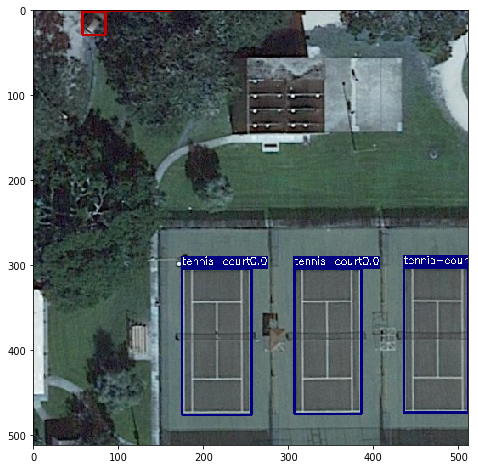

In [5]:
img_name, img, targets = validation_dataset.__getitem__(410)

plt.figure(figsize=(8,8),facecolor='w') 
visualize_bbox_gt(img_name, train = False, img_size = 512)

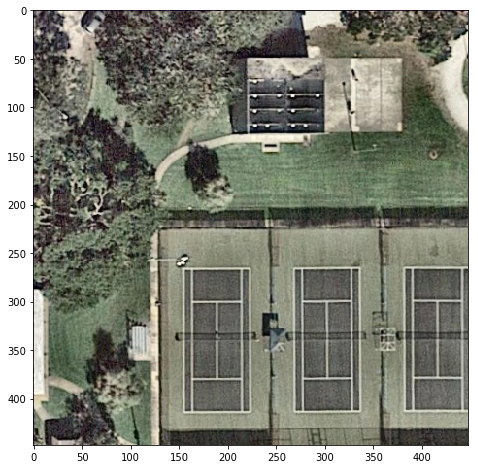

In [6]:
plt.figure(figsize=(8,8),facecolor='w')
plt.imshow(img.permute(1,2,0))

In [7]:
idx = validation_dataset.image_names.index(img_name)
gt_bbox = validation_dataset.targets[idx]
print(gt_bbox.size())

conobj_mask = (targets[:,:,4] > 0).unsqueeze(-1).expand_as(targets)
conobj_bbox_train = targets[conobj_mask].view(-1,26)
print(conobj_bbox_train.size())

torch.Size([4, 5])
torch.Size([4, 26])


## Load Model

In [8]:
model = Yolov1_vgg16bn(pretrained = True)
model.load_state_dict(torch.load('models/encurage_detect/stage_30_model.pth'))
model.eval()

if use_gpu:
    model.cuda()

## Predict One

**Processing after prediction**
1. bounding box(tensor): sized [98 ,4], [xmin, ymin, xmax, ymin]
2. class confidence(tensor): sized [98 ,1], max class prob * IoU confidence
3. class probability(tensor): sized [98, 16]

In [9]:
img_tensor = Variable(img)
if use_gpu:
    img_tensor = img_tensor.cuda()

with torch.no_grad():
    img_tensor = img_tensor.unsqueeze(0)
    pred = model(img_tensor) # sized [1,7,7,26]

    
"""
Data processing
    1. bounding box(tensor): sized [98 ,4], [xmin, ymin, xmax, ymin]
    2. class confidence(tensor): sized [98 ,1], max class prob * IoU confidence
    3. class probability(tensor): sized [98, 16]
"""

#pred = targets.unsqueeze(0)

pred = pred.squeeze(0).view(-1,26).cpu()  # sized [49, 26]
pred_bbox = pred[:, :10].contiguous().view(-1,5) # sized [98 , 5]
pred_cls = pred[:, 10:]  # sized [49, 16]
pred_cls = torch.cat((pred_cls, pred_cls), 1).view(-1, 16)  # sized [98, 16]

g = range(GRID_NUM)
g_idx = torch.Tensor(np.transpose([np.repeat(g, len(g)), np.tile(g, len(g))]))   # sized [49 , 2]
g_idx = torch.cat((g_idx, g_idx), 1).view(-1,2)   # sized [98 , 2]

# rescale bbox point back to original size
grid_length = ORIGINAL_IMAGE_SIZE / float(GRID_NUM)
#grid_length = TRAIN_IMAGE_SIZE / float(GRID_NUM)
anchor_points = g_idx * grid_length # sized [98, 2]

pred_bbox_cxcy = pred_bbox[:, :4]   # sized [98, 4]
pred_bbox_xy = torch.Tensor(pred_bbox_cxcy.size())
# xmin, ymin = ((cx, cy) + (ax, ay))*grid_length - (w,h) * original_size
pred_bbox_xy[:, :2] = (pred_bbox_cxcy[:, :2] * grid_length + anchor_points)  - pred_bbox_cxcy[:, 2:] * ORIGINAL_IMAGE_SIZE
# xmax, ymax = ((cx, cy) + (ax, ay))*grid_length + (w,h) * original_size
pred_bbox_xy[:, 2:4] = (pred_bbox_cxcy[:, :2] * grid_length + anchor_points) + pred_bbox_cxcy[:, 2:] * ORIGINAL_IMAGE_SIZE

# class confidence
# object confidence * max class prob
obj_conf = pred_bbox[:, 4].unsqueeze(1)   # sized [98, 1]
max_cls_prob = torch.max(pred_cls, 1)[0].view(-1,1)  # sized [98, 1]
cls_conf = obj_conf.mul(max_cls_prob)  # sized [98, 1] 


In [10]:
torch.sum(cls_conf > 0.01)
print(cls_conf)

tensor([[0.0431],
        [0.0670],
        [0.0302],
        [0.0130],
        [0.0099],
        [0.0266],
        [0.0237],
        [0.0106],
        [0.0158],
        [0.0161],
        [0.0285],
        [0.0161],
        [0.0128],
        [0.0310],
        [0.0876],
        [0.0470],
        [0.0149],
        [0.0029],
        [0.0284],
        [0.0068],
        [0.0079],
        [0.0123],
        [0.0092],
        [0.0051],
        [0.0116],
        [0.0155],
        [0.0124],
        [0.0076],
        [0.0494],
        [0.0087],
        [0.0304],
        [0.0154],
        [0.0064],
        [0.0027],
        [0.0102],
        [0.0386],
        [0.0068],
        [0.0632],
        [0.0033],
        [0.2382],
        [0.0273],
        [0.0314],
        [0.0313],
        [0.0095],
        [0.0053],
        [0.0142],
        [0.0230],
        [0.0117],
        [0.0172],
        [0.0075],
        [0.0155],
        [0.0905],
        [0.0077],
        [0.3411],
        [0.0485],
        [0

## Filtering

1. filtering by class confidence
2. NMS

**Results**
1. high confidence bounding boxes_xy (tensor), sized [N, 4]: [xmin, ymin, xmax, ymax]
2. high confidence of class (tensor), sized [N, 1]
3. high confidence of class probability (tensor), sized [N, 16]

In [11]:
hconf_pass = (cls_conf > hconf_threh)  # sized [98, 1] 0 or 1

# high confidence bbox
hconf_bbox_xy_pass = hconf_pass.expand_as(pred_bbox_xy)  # sized [98 , 4]
hconf_bbox_xy = pred_bbox_xy[hconf_bbox_xy_pass].view(-1, 4)  # sized [M, 4]

# high confidence class confidence
hconf_cls_conf = cls_conf[hconf_pass]  # sized [, M]

# high confidence class prediction
hconf_pred_cls_pass = hconf_pass.expand_as(pred_cls)
hconf_pred_cls = pred_cls[hconf_pred_cls_pass].view(-1, 16)  # sized [M, 16]

# NMS filtering
nms_pass = nms(hconf_bbox_xy, hconf_cls_conf)  # sized [, N]
nms_pass = nms_pass.view(-1,1)  # sized [N ,1]

# final bbox
bbox_xy_final = hconf_bbox_xy[nms_pass].squeeze(1)

# final class confidence
cls_conf_final = hconf_cls_conf[nms_pass].squeeze(1)

# final class probability
pred_cls_final = hconf_pred_cls[nms_pass].squeeze(1)

# class names
max_cls_idx = torch.max(pred_cls_final, 1)[1].tolist() if pred_cls_final.size(0) > 0 else []
cls_labels = [DOTA_CLASSES[idx] for idx in max_cls_idx]

In [12]:
cls_conf_final

tensor([0.4129, 0.3411, 0.3400, 0.2630, 0.2382, 0.2249, 0.1151, 0.1056, 0.0905,
        0.0876, 0.0793, 0.0679, 0.0672, 0.0670, 0.0647, 0.0632, 0.0596, 0.0529,
        0.0494, 0.0485, 0.0470, 0.0431, 0.0386, 0.0371, 0.0367, 0.0366, 0.0352,
        0.0328, 0.0322, 0.0314, 0.0313, 0.0310, 0.0304, 0.0302, 0.0285, 0.0284,
        0.0273, 0.0268, 0.0266, 0.0266, 0.0255, 0.0243, 0.0237, 0.0230, 0.0223,
        0.0221, 0.0220, 0.0215, 0.0184, 0.0172, 0.0167, 0.0161, 0.0161, 0.0158,
        0.0155, 0.0155, 0.0154, 0.0149, 0.0145, 0.0142, 0.0130, 0.0129, 0.0128,
        0.0124, 0.0123, 0.0117, 0.0116, 0.0108, 0.0106, 0.0102, 0.0101, 0.0099,
        0.0095, 0.0093, 0.0092, 0.0087, 0.0085, 0.0082, 0.0081, 0.0079, 0.0077,
        0.0076, 0.0075, 0.0075, 0.0069, 0.0068, 0.0068, 0.0068, 0.0064, 0.0057,
        0.0053, 0.0051, 0.0050, 0.0033, 0.0030, 0.0030, 0.0029, 0.0027])

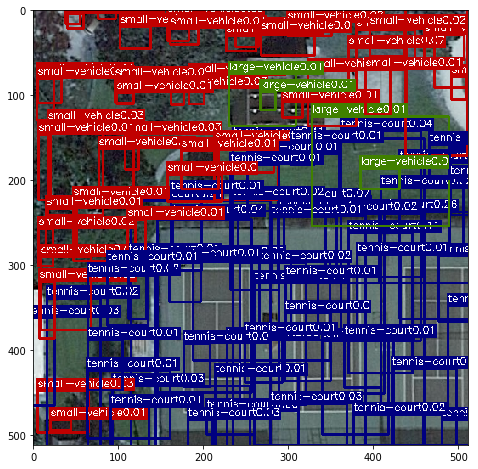

In [13]:
plt.figure(figsize=(8,8),facecolor='w')
visualize_bbox(img_name, bbox_xy_final.tolist(), cls_labels, cls_conf_final.tolist(), img_size = 512, train = False)